## Deterministric Model
### Exercise 1

In [1]:
import torch
import MNIST_dataloader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from torch import nn, optim
from typing import Dict, Optional, Tuple, List
import sys

In [52]:
# %% set torches random seed
torch.random.manual_seed(0)

model_loc = os.path.join(os.path.abspath("."),"model")
fig_path = os.path.join(os.path.abspath("."),"figure")

In [3]:
# %% preperations
# define parameters

data_loc = os.path.join(os.path.abspath("."),"MNIST") #change the data location to something that works for you
batch_size = 64
train_loader, test_loader = MNIST_dataloader.create_dataloaders(data_loc, batch_size)


In [4]:
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

In [5]:
# Define Autoencoder
# Encoder

class Encoder(nn.Module):
    def __init__(self,in_channel=3):
        super(Encoder, self).__init__()
        # create layers here
        self.encoder = nn.Sequential(
        nn.Conv2d(in_channel,16,kernel_size=3,padding=1), #(N,3,32,32)->(N,16,32,32)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), #(N,16,32,32)->(N,16,16,16)
        nn.Conv2d(16,16,3,padding=1), #(N,16,16,16)->(N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,16,16)->(N,16,8,8)
        nn.Conv2d(16,16,3,padding=1), #(N,16,8,8)->(N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,4,4)
        nn.Conv2d(16,1,3,padding=1), #(N,16,4,4)->(N,1,4,4)
        nn.ReLU(),
        nn.MaxPool2d((2,4)) # (N,1,2,1)
        )
        
    def forward(self, x):
        # use the created layers here
        x = self.encoder(x)
        return x
    
# Decoder
class Decoder(nn.Module):
    def __init__(self,out_channel=3):
        super(Decoder, self).__init__()
        # create layers here
        self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=(2,4)), #(N,1,2,1)->(N,1,4,4)
        nn.ConvTranspose2d(1,16,3,padding=1), # (N,16,4,4)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,4,4)->(N,16,8,8)
        nn.ConvTranspose2d(16,16,3,padding=1), # (N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,8,8)->(N,16,16,16)
        nn.ConvTranspose2d(16,16,3,padding=1), # (N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Upsample(scale_factor=2), #(N,16,32,32)->(N,16,32,32)
        nn.ConvTranspose2d(16,out_channel,3,padding=1), # (N,16,32,32)
        )
        
    def forward(self, h):
        # use the created layers here
        r = self.decoder(h)
        return r
    
# Autoencoder
class AE(nn.Module):
    def __init__(self,channel=3):
        super(AE, self).__init__()
        self.encoder = Encoder(channel)
        self.decoder = Decoder(channel)
        
    def forward(self, x):
        h = self.encoder(x)
        r = self.decoder(h)
        return r, h

In [6]:
# Sanity check
sanity_check = torch.ones((64,3,32,32))
encoder_check = Encoder(3)
latent = encoder_check.forward(sanity_check)
print(latent.shape)
decoder_check = Decoder(3)
print(decoder_check.forward(latent).shape)
AE_check = AE(3)
r,h = AE_check.forward(sanity_check)
print(r.shape)
print(h.shape)

torch.Size([64, 1, 2, 1])
torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64, 1, 2, 1])


## Trainer

In [10]:
model_1 = AE(1)
no_epochs = 10
learning_rate = 3e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer_1 = optim.Adam(model_1.parameters(),lr = learning_rate)
critereon = nn.MSELoss()

In [11]:
#using clean image to train x_clean_train
model_1.train()
loss_iter = []
loss_epoch = []
torch.random.manual_seed(0)
for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    sys.stdout.flush()
    total_loss=0
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        optimizer_1.zero_grad()
        inputs = x_clean.to(device=device)
        model_1 = model_1.to(device=device)
        outputs,latent = model_1(inputs)
        loss = critereon(outputs,inputs)
        loss.backward()
        optimizer_1.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],MSE loss:{total_loss/len(train_loader)}')
    sys.stdout.flush()
        

Training on cpu. Epoch 1:


100%|██████████| 938/938 [01:11<00:00, 13.09it/s]

epoch[1/10],MSE loss:0.24125370383262634
Training on cpu. Epoch 2:



100%|██████████| 938/938 [01:10<00:00, 13.25it/s]

epoch[2/10],MSE loss:0.18830130994319916
Training on cpu. Epoch 3:



100%|██████████| 938/938 [01:10<00:00, 13.33it/s]

epoch[3/10],MSE loss:0.17968498170375824
Training on cpu. Epoch 4:



100%|██████████| 938/938 [01:09<00:00, 13.47it/s]

epoch[4/10],MSE loss:0.1746770739555359
Training on cpu. Epoch 5:



100%|██████████| 938/938 [01:09<00:00, 13.52it/s]

epoch[5/10],MSE loss:0.17080961167812347
Training on cpu. Epoch 6:



100%|██████████| 938/938 [01:09<00:00, 13.58it/s]

epoch[6/10],MSE loss:0.16768746078014374
Training on cpu. Epoch 7:



100%|██████████| 938/938 [01:09<00:00, 13.56it/s]

epoch[7/10],MSE loss:0.1651296317577362
Training on cpu. Epoch 8:



100%|██████████| 938/938 [01:09<00:00, 13.58it/s]

epoch[8/10],MSE loss:0.16296568512916565
Training on cpu. Epoch 9:



100%|██████████| 938/938 [01:08<00:00, 13.60it/s]

epoch[9/10],MSE loss:0.1612703502178192
Training on cpu. Epoch 10:



100%|██████████| 938/938 [01:09<00:00, 13.58it/s]

epoch[10/10],MSE loss:0.16003935039043427


In [12]:
model_loc = os.path.join(os.path.abspath("."),"model")
torch.save(model_1,os.path.join(model_loc,"exercise1.ptg"))

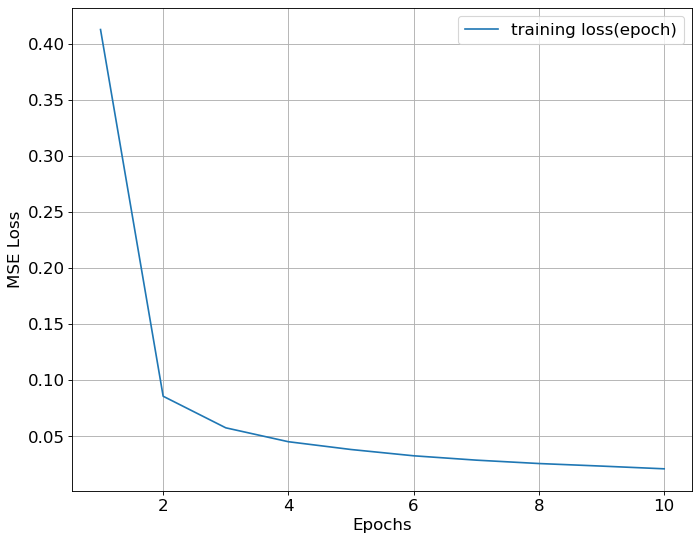

In [42]:
"""
Visualize the first 10 images of example_clean next to the output of this batch. What
differences/resemblances you do notice between the input and output of the autoencoder?
Also make a plot of the loss as a function of the number of iterations or epochs.
"""
plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.plot(range(len(loss_iter)),loss_iter,label='training loss(iteration)',linestyle=':')
plt.plot(range(1,no_epochs+1),loss_epoch,label='training loss(epoch)',linestyle='-')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("MSE Loss",fontdict={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise1_loss_plot.png"),dpi=80,bbox_inches='tight')

plt.show()

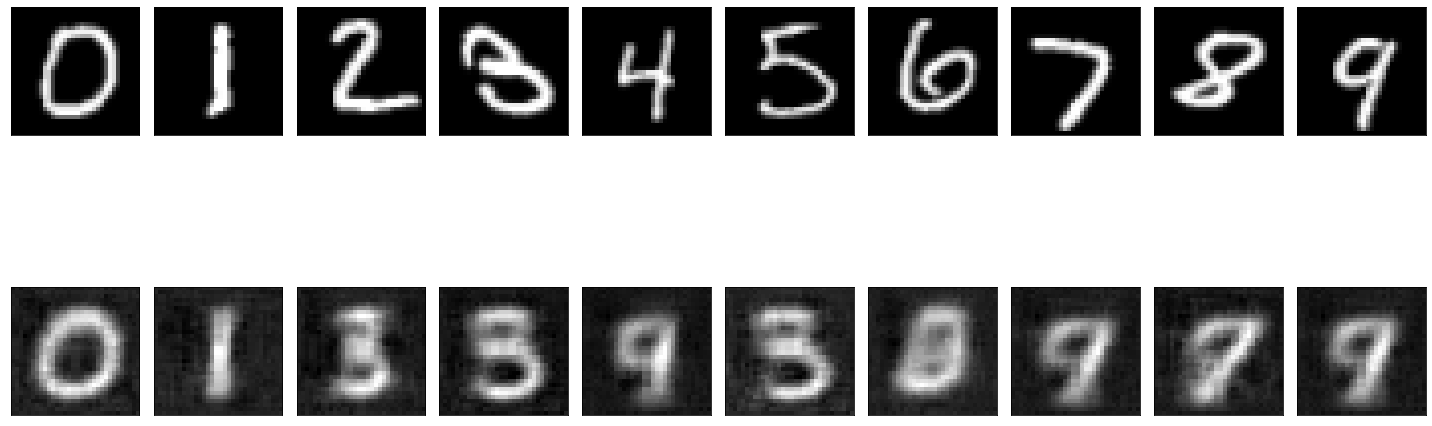

In [28]:
# x_clean_test = train_loader.dataset.Clean_Images
# x_clean_example = x_clean_test[0:10,:,:,:]
# with torch.no_grad():
#     outputs_clean,_ = model_1(x_clean_example)
model_1 = torch.load(os.path.join(model_loc,"exercise1.ptg"))
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
with torch.no_grad():
    outputs_clean,latent = model_1(x_clean_example)

plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,10,i+11)
    plt.imshow(outputs_clean[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise1_examples.png"),dpi=80,bbox_inches='tight')
plt.show()

-  2->3
-  3->6/8 
-  4->9
-  5->8
-  6->8
-  8->3

## Exercise 2

In [29]:
model_1.eval()
with torch.no_grad():
    _,latent = model_1(x_clean_test)
latent=latent.squeeze()


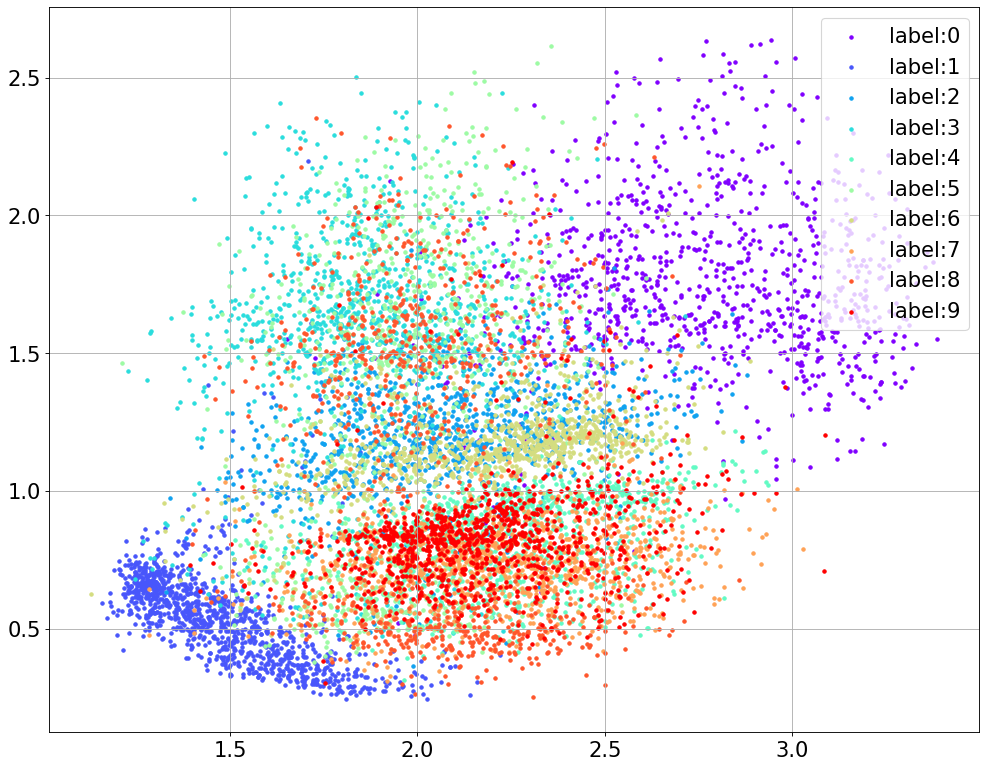

In [37]:
import matplotlib.cm as cm
import numpy as np

colors = cm.rainbow(np.linspace(0, 1,10))
plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')
for i in range(10):
    c = colors[i]
    latent_c = latent[torch.where(labels_test==i)]
    # if i == 3 or i==6:
    plt.scatter(latent_c[:,0], latent_c[:,1], color=c,label=f"label:{i}",marker='.')

plt.xticks(size=19)
plt.yticks(size=19)
plt.legend(loc=1,prop={'size': 19})
plt.grid()
plt.savefig(os.path.join(fig_path,"Exercise2.png"),dpi=80,bbox_inches='tight')
plt.show()

### 2b)
- 0,1,9 provide clear clusters.
- Others are overlapped?
### 2c)
- What does it mean?

## Exercise 3
### a)
 将训练集的隐空间的每个数据点对应到测试集的隐空间中每个数据点。对应方式是欧氏距离最小。你可以认为两张图片映射到隐空间中后，有相当高的可能性两者的特征是类似的。 因此，可以把训练集图片的标签按照赋予其隐空间中最近邻的测试图片。
 对于测试集中1000张图片完成上述任务，并展示十个类别的准确度

In [31]:
from sklearn.neighbors import NearestNeighbors

model_1 = torch.load(os.path.join(model_loc,"exercise1.ptg"))
with torch.no_grad():
    _,latent_test = model_1(x_clean_test[0:1000,:,:,:]) #[1000,1,2,1]
    _,latent_train = model_1(x_clean_train) #[60000,1,2,1]


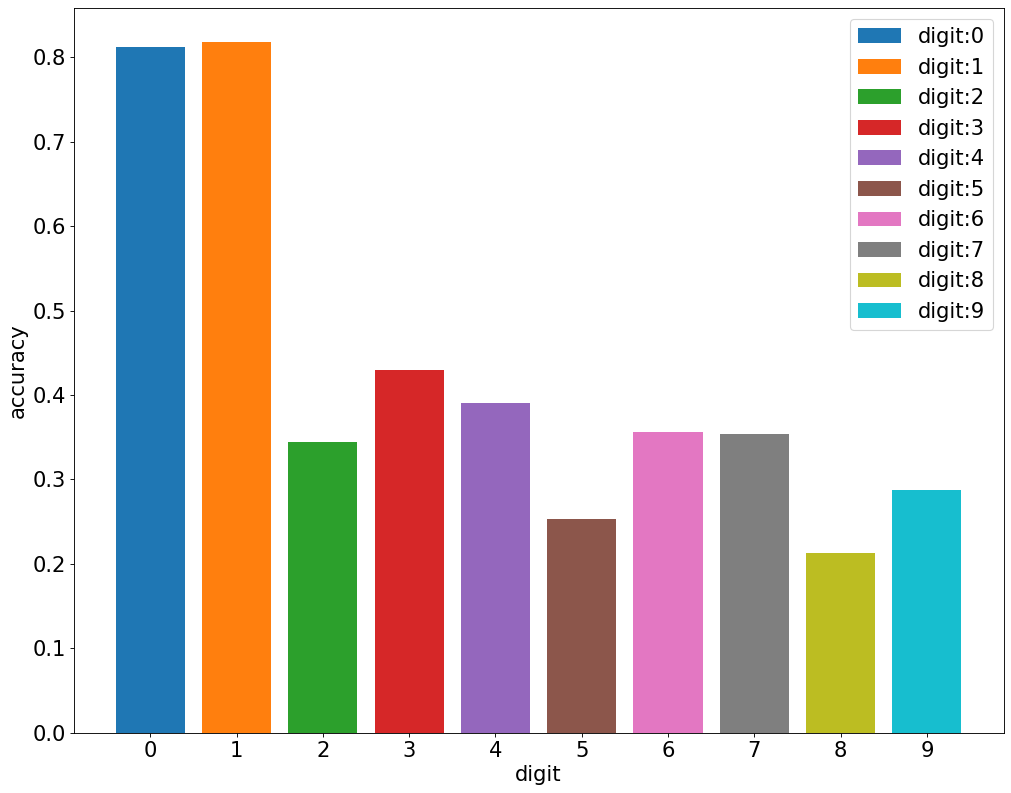

In [40]:
latent_test = latent_test.squeeze() #[1000,2]
latent_train = latent_train.squeeze() #[60000,2]
nbrs = NearestNeighbors(n_neighbors=1).fit(latent_train)
_,indices = nbrs.kneighbors(latent_test)

# matched labels
label_latent_test1000 = labels_train[indices].squeeze()

accuracy = []

plt.figure(figsize=(15,12),dpi=80, facecolor='w', edgecolor='k')

for i in range(10):
    # indices which ground truth in test set is digit "i"
    digit_indices = torch.where(labels_test[0:1000]==i)[0]
    accuracy.append(sum(labels_train[indices[digit_indices]]==i)/len(digit_indices))
    plt.bar(i,accuracy[i],label = f"digit:{i}")

plt.xticks(np.arange(0,10,1),size=19)
plt.yticks(size=19)
plt.xlabel("digit",fontdict={'size':19})
plt.ylabel("accuracy",fontdict={'size':19})
plt.legend(loc=1,prop={'size': 19})
# plt.grid()
plt.savefig(os.path.join(fig_path,"Exercise3.png"),dpi=80,bbox_inches='tight')
plt.show()

### b)
I would expect 100 correct classifications. The probability of correct classfication is 10%.   
<font color=red>I am not sure if this is the right answer...</font>
### c)
I would use cross entropy loss for a multiclass classification task



## Exercise 4

In [33]:
# Define FC_Encoder for classification

class FC_Encoder(nn.Module):
    def __init__(self,in_channel=3):
        super(FC_Encoder, self).__init__()
        # create layers here
        self.encoder = nn.Sequential(
        nn.Conv2d(in_channel,16,kernel_size=3,padding=1), #(N,3,32,32)->(N,16,32,32)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), #(N,16,32,32)->(N,16,16,16)
        nn.Conv2d(16,16,3,padding=1), #(N,16,16,16)->(N,16,16,16)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,16,16)->(N,16,8,8)
        nn.Conv2d(16,16,3,padding=1), #(N,16,8,8)->(N,16,8,8)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2), # (N,16,4,4)
        # nn.Conv2d(16,1,3,padding=1), #(N,16,4,4)->(N,1,4,4)
        # nn.ReLU(),
        # nn.MaxPool2d((2,4)) # (N,1,2,1)
        nn.Flatten(),
        nn.Linear(16*4*4,10),
        nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # use the created layers here
        x = self.encoder(x)
        return x


In [36]:
model_4 = FC_Encoder(in_channel=1)
loss_4 = torch.nn.CrossEntropyLoss()
optimizer_4 = torch.optim.Adam(model_4.parameters(),lr=learning_rate)

#using clean image to train x_clean_train
loss_iter = []
loss_epoch = []
loss_iter_test = []
loss_epoch_test = []
torch.random.manual_seed(0)
model_4 = model_4.to(device=device)

for epoch in range(no_epochs):
    print(f"Training on {device}. Epoch {epoch+1}:")
    # go over all minibatches
    sys.stdout.flush()
    total_loss=0
    model_4.train()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(train_loader)):
        # fill in how to train your network using only the clean images
        optimizer_4.zero_grad()
        inputs = x_clean.to(device=device)
        outputs= model_4(inputs)
        loss = loss_4(outputs,label)
        loss.backward()
        optimizer_4.step()
        loss_iter.append(loss.data)
        total_loss += loss.data
    loss_epoch.append(total_loss/len(train_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],Cross Entropy Loss(Train):{total_loss/len(train_loader)}')
    sys.stdout.flush()
    sys.stdout.flush()
    total_loss = 0
    model_4.eval()
    for batch_idx,(x_clean, x_noisy, label) in enumerate(tqdm(test_loader)):
        inputs = x_clean.to(device=device)
        outputs= model_4(inputs)
        loss_test = loss_4(outputs,label)
        loss_iter_test.append(loss_test.data)
        total_loss += loss_test.data
    loss_epoch_test.append(total_loss/len(test_loader))
    print(f'epoch[{epoch+1}/{no_epochs}],Cross Entropy Loss(Test):{total_loss/len(test_loader)}')
    
    sys.stdout.flush()
torch.save(model_4,os.path.join(model_loc,'exercise4.ptg'))

Training on cpu. Epoch 1:


100%|██████████| 938/938 [00:30<00:00, 30.72it/s]

epoch[1/10],Cross Entropy Loss(Train):0.4125784933567047



100%|██████████| 157/157 [00:02<00:00, 61.17it/s]

epoch[1/10],Cross Entropy Loss(Test):0.11466436088085175
Training on cpu. Epoch 2:



100%|██████████| 938/938 [00:33<00:00, 27.74it/s]

epoch[2/10],Cross Entropy Loss(Train):0.08559156954288483



100%|██████████| 157/157 [00:02<00:00, 70.97it/s]

epoch[2/10],Cross Entropy Loss(Test):0.07569500058889389
Training on cpu. Epoch 3:



100%|██████████| 938/938 [00:31<00:00, 30.24it/s]

epoch[3/10],Cross Entropy Loss(Train):0.057424962520599365



100%|██████████| 157/157 [00:02<00:00, 75.04it/s]

epoch[3/10],Cross Entropy Loss(Test):0.062255483120679855
Training on cpu. Epoch 4:



100%|██████████| 938/938 [00:29<00:00, 31.60it/s]

epoch[4/10],Cross Entropy Loss(Train):0.04502585902810097



100%|██████████| 157/157 [00:01<00:00, 78.63it/s]

epoch[4/10],Cross Entropy Loss(Test):0.0554826520383358
Training on cpu. Epoch 5:



100%|██████████| 938/938 [00:27<00:00, 33.93it/s]

epoch[5/10],Cross Entropy Loss(Train):0.03808656707406044



100%|██████████| 157/157 [00:01<00:00, 80.64it/s]

epoch[5/10],Cross Entropy Loss(Test):0.05396939441561699
Training on cpu. Epoch 6:



100%|██████████| 938/938 [00:27<00:00, 34.10it/s]

epoch[6/10],Cross Entropy Loss(Train):0.03248348832130432



100%|██████████| 157/157 [00:01<00:00, 79.87it/s]

epoch[6/10],Cross Entropy Loss(Test):0.05008257180452347
Training on cpu. Epoch 7:



100%|██████████| 938/938 [00:27<00:00, 33.99it/s]

epoch[7/10],Cross Entropy Loss(Train):0.028602004051208496



100%|██████████| 157/157 [00:02<00:00, 72.81it/s]

epoch[7/10],Cross Entropy Loss(Test):0.051309313625097275
Training on cpu. Epoch 8:



100%|██████████| 938/938 [00:29<00:00, 32.33it/s]

epoch[8/10],Cross Entropy Loss(Train):0.02558063715696335



100%|██████████| 157/157 [00:02<00:00, 67.78it/s]

epoch[8/10],Cross Entropy Loss(Test):0.05209508538246155
Training on cpu. Epoch 9:



100%|██████████| 938/938 [00:29<00:00, 32.05it/s]

epoch[9/10],Cross Entropy Loss(Train):0.023294268175959587



100%|██████████| 157/157 [00:01<00:00, 82.36it/s]

epoch[9/10],Cross Entropy Loss(Test):0.050872184336185455


Training on cpu. Epoch 10:


100%|██████████| 938/938 [00:27<00:00, 34.02it/s]

epoch[10/10],Cross Entropy Loss(Train):0.020870279520750046



100%|██████████| 157/157 [00:01<00:00, 84.91it/s]

epoch[10/10],Cross Entropy Loss(Test):0.049624379724264145


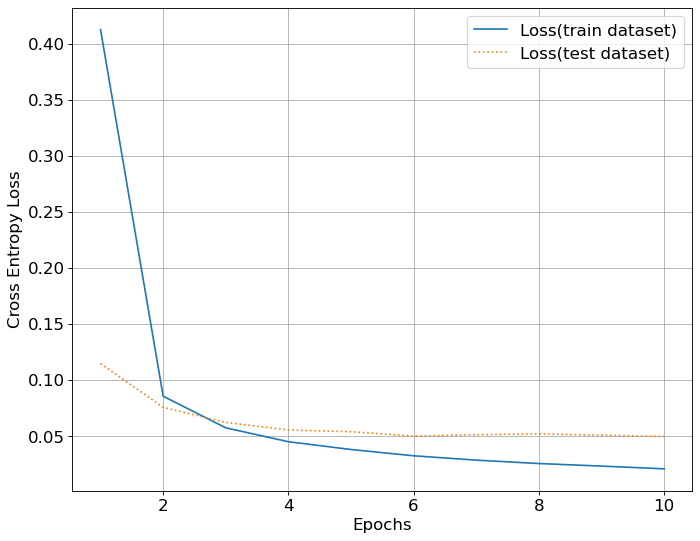

In [39]:
plt.figure(figsize=(10,8),dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(1,2,1)
plt.plot(range(1,no_epochs+1),loss_epoch,label='Loss(train dataset)',linestyle='-')
plt.plot(range(1,no_epochs+1),loss_epoch_test,label='Loss(test dataset)',linestyle=':')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("Cross Entropy Loss",fontdict={'size':15})

plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.savefig(os.path.join(fig_path,"Exercise4_loss.png"),dpi=80,bbox_inches='tight')
plt.show()

In [22]:
model_4 = torch.load(os.path.join(model_loc,"exercise4.pth"))
model_4 = model_4.to(device=device)
model_4.eval()
accuracy_4 = []
total_accu = 0
with torch.no_grad():
    y_test_4 = model_4(x_clean_test[0:1000,:,:,:])
    for i in range(10):
        tp=0
        digit_indices = torch.where(labels_test[0:1000]==i)[0]
        # torch.max() returns values,indices
        label_model_4 = torch.max(y_test_4[digit_indices],dim=1)[1]
        tp += (label_model_4==labels_test[digit_indices]).sum()
        total_accu += tp
        accuracy_4.append(tp.item()/(len(digit_indices)))

print(f"Accuracy:{total_accu.item()/1000}")

Accuracy:0.972


## Exercise 5

In [49]:
x = torch.arange(1,3.5,2.5/15)
y = torch.arange(0,3,3/15)
latent_5 = torch.zeros((15*15,1,2,1),requires_grad=False)
for i in range(15):
    for j in range(15):
        latent_5[i*15+j,0,:,0] = torch.Tensor([x[i],y[j]])



In [50]:
model_1 = torch.load(os.path.join(model_loc,"exercise1.ptg"))
with torch.no_grad():
    output_5 = model_1.decoder(latent_5)


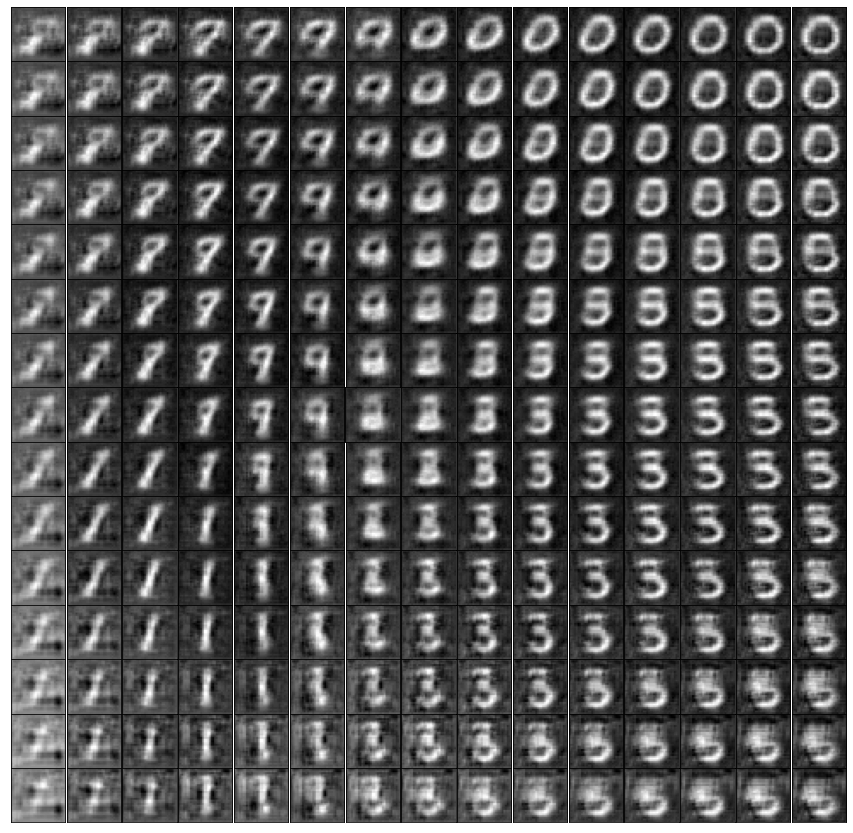

In [51]:

plt.figure(figsize=(15,15))
for i in range(15):
    for j in range(15):
        plt.subplot(15,15,i*15+j+1)
        plt.imshow(output_5[(14-i)*15+j,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

plt.subplots_adjust(wspace=0,hspace=0)
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise5.png"),dpi=80,bbox_inches='tight')
plt.show()

### b)
Digits 9, 0, 3, and 1 can be recoginized.  

## Exercise 6

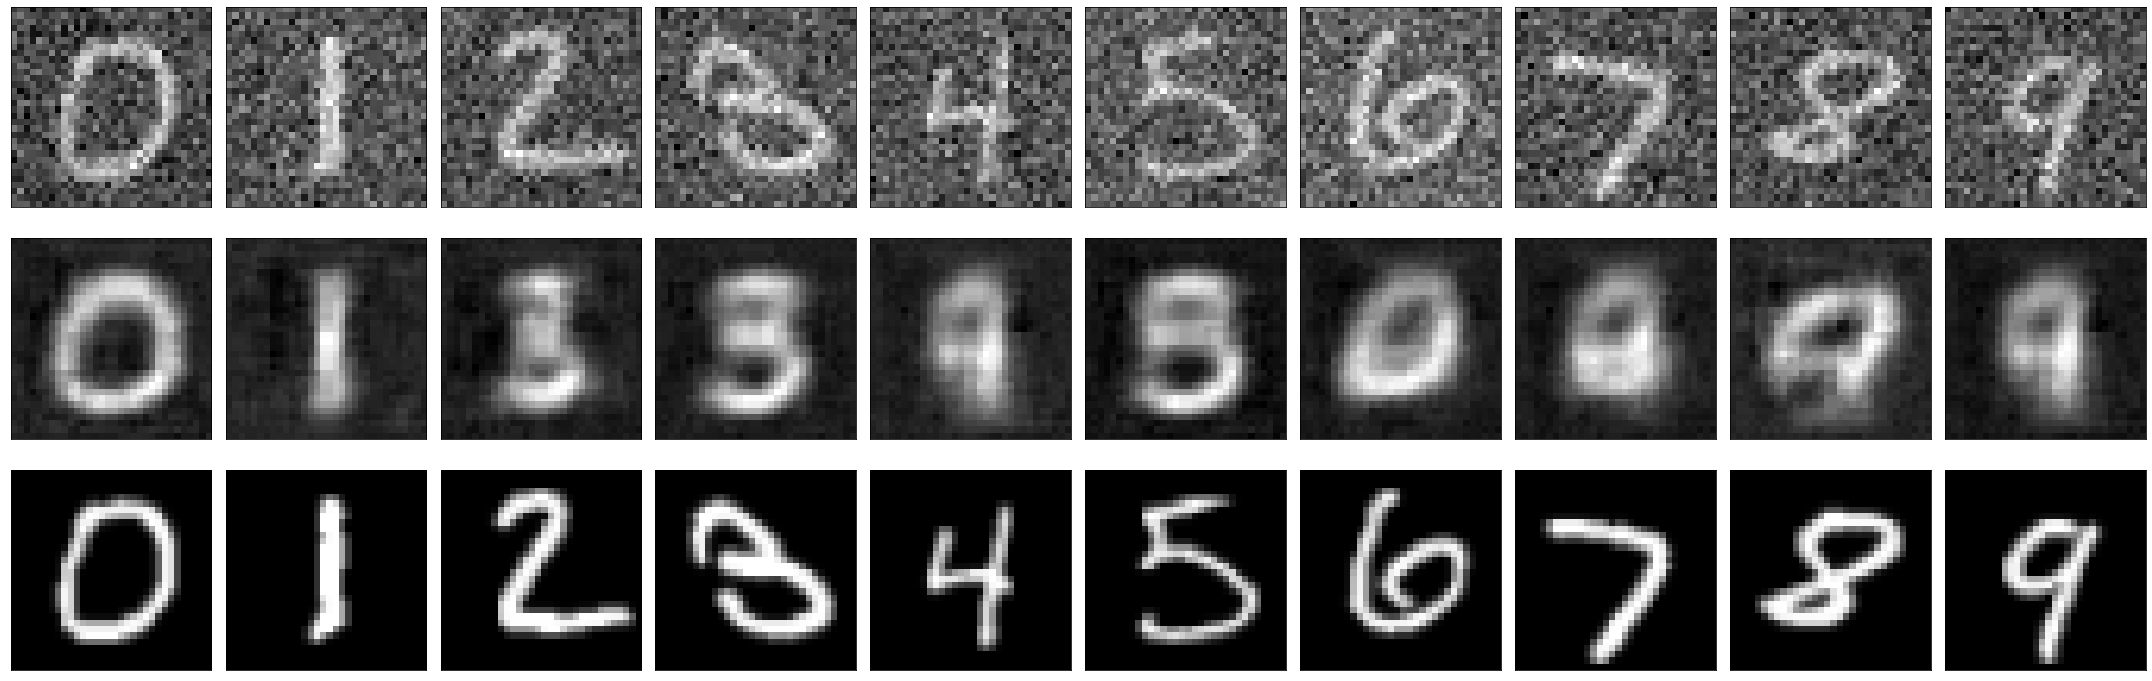

In [53]:
model_1 = torch.load(os.path.join(model_loc,"exercise1.ptg"))

with torch.no_grad():
    outputs_noisy,_ = model_1(x_noisy_example)

plt.figure(figsize=(30,10))
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+11)
    plt.imshow(outputs_noisy[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+21)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
fig_path = os.path.join(os.path.abspath("."),"figure")
plt.savefig(os.path.join(fig_path,"exercise6_examples.png"),dpi=80,bbox_inches='tight')
plt.show()
    



Noise is canceled. However, the autoencoder failed to recover some digits. 